# Assignment 1 Development of a Neural Network for Microstructure-Property Predictions

Students: Ian Marchetti Meirelles, Juan Manuel Bonilla

# Notebook for Training the Model on Google Colab

> ⚠️ **Note:**  
> This notebook is intended for training the model on **Google Colab**.  
> It clones the project repository for access to the necessary code and data.  
> However, the notebook itself is also **committed in the repository**, so paths and setup steps may need to be adjusted accordingly depending on your environment.


## Cloning repository and unzip data:
Obs: do not forget to also add the material_properties.csv inside the folder "data/properties" after cloning.

In [2]:
!git clone https://github.com/ianmm2d/Microstructure-Predictions.git
import os

# Change working directory from /content to your repo folder
os.chdir('/content/Microstructure-Predictions')

# Now unzip your data
!unzip -q data/npy_images/microstructures_zip.zip -d data/npy_images/

Cloning into 'Microstructure-Predictions'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 119 (delta 47), reused 88 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (119/119), 2.36 MiB | 5.97 MiB/s, done.
Resolving deltas: 100% (47/47), done.
replace data/npy_images/.gitkeep? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Importing modules and libraries:

In [1]:
%cd /content/Microstructure-Predictions

/content/Microstructure-Predictions


In [2]:
from src.pipeline import DataPipeline
from src.model import CNN
from src.train import train_and_evaluate, plot_loss_curves
from src.inference import load_model, predict, evaluate_predictions
import numpy as np
import torch
import matplotlib.pyplot as plt
print("Imports successful!")

Imports successful!


## Run data pipeline:

In [23]:
#Data loading and preprocessing
image_dir = 'data/npy_images'
label_path = 'data/properties/material_property.csv'
batch_size = 16
test_split = 0.9 # 90% unused during training (9000 samples)
val_split = 0.02 # 2% of data being used for validation, 8% for training (200 and 800 samples)
pipeline = DataPipeline(image_dir, label_path,batch_size, test_split, val_split)
dataloaders = pipeline.load()
train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

## Train settings:

In [30]:
# Initialize the model, loss function, and optimizer
sample_input, _ = next(iter(train_loader))
_, c, h, w = sample_input.shape
model = CNN(input_channels=c, input_height=h, input_width=w)
loss = torch.nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
epochs = 50
seed = 30

## Training:

Epoch 1/50, Train Loss: 0.2682, Val Loss: 0.0474
Epoch 2/50, Train Loss: 0.0267, Val Loss: 0.0211
Epoch 3/50, Train Loss: 0.0151, Val Loss: 0.0179
Epoch 4/50, Train Loss: 0.0214, Val Loss: 0.0185
Epoch 5/50, Train Loss: 0.0113, Val Loss: 0.0195
Epoch 6/50, Train Loss: 0.0106, Val Loss: 0.0244
Epoch 7/50, Train Loss: 0.0096, Val Loss: 0.0114
Epoch 8/50, Train Loss: 0.0038, Val Loss: 0.0127
Epoch 9/50, Train Loss: 0.0035, Val Loss: 0.0130
Epoch 10/50, Train Loss: 0.0041, Val Loss: 0.0103
Epoch 11/50, Train Loss: 0.0031, Val Loss: 0.0114
Epoch 12/50, Train Loss: 0.0028, Val Loss: 0.0136
Epoch 13/50, Train Loss: 0.0021, Val Loss: 0.0107
Epoch 14/50, Train Loss: 0.0018, Val Loss: 0.0099
Epoch 15/50, Train Loss: 0.0023, Val Loss: 0.0093
Epoch 16/50, Train Loss: 0.0017, Val Loss: 0.0110
Epoch 17/50, Train Loss: 0.0011, Val Loss: 0.0108
Epoch 18/50, Train Loss: 0.0028, Val Loss: 0.0106
Epoch 19/50, Train Loss: 0.0030, Val Loss: 0.0106
Epoch 20/50, Train Loss: 0.0016, Val Loss: 0.0096
Epoch 21/

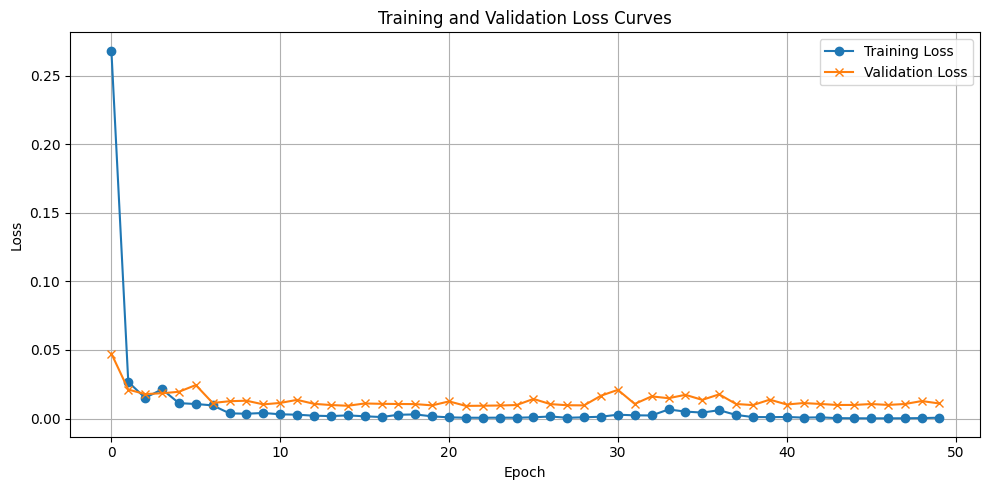

In [31]:
# Train the model
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss, optimizer, epochs, seed=seed)
# Plot training and validation loss curves
plot_loss_curves(train_losses, val_losses)

## Evaluating model for train dataset:

**Evaluation Metric:**

$$
\text{accuracy} = \frac{| E_{eff}^{\text{predicted}} -  E_{eff}^{\text{true}} |}{E_{eff}^{\text{true}}}
$$

This metric represents the **relative error** between the predicted and true effective Young’s modulus values.

We define a prediction as *accurate* if its relative error is **below 0.3**, i.e., within 30% of the true value.

To assess model performance, we implemented the function `evaluate_predictions`, which takes a dataloader as input and returns:

- The **percentage of predictions** within the 30% relative error threshold;
- The **average relative error** (mean accuracy);
- Optionally, prints verbose details for inspection;

In [33]:
sample_input, _ = next(iter(train_loader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Make predictions
predictions, targets = predict(model, dataloader=train_loader, device=device, pipeline=pipeline)
# Evaluate predictions
mean_error, accuracy = evaluate_predictions(predictions, targets, threshold=0.30, verbose=True)

Sample predictions and targets:
Predictions: [[1.4662710e+09]
 [2.8156393e+09]
 [3.3064504e+09]
 [3.3149688e+09]
 [1.3374803e+09]
 [1.2093283e+09]
 [3.3164864e+09]
 [4.2377866e+09]
 [4.1328558e+09]
 [4.1208643e+09]]
Targets: [[1.4771596e+09]
 [2.7977331e+09]
 [3.3425820e+09]
 [3.3172019e+09]
 [1.3391251e+09]
 [1.2276513e+09]
 [3.3171116e+09]
 [4.2354655e+09]
 [4.1403799e+09]
 [4.1565847e+09]]
Percentage of data inside threshold accuracy: 100.00%
Percentage of Mean relative error for inference: 0.6146%


## Evaluating model for val dataset:

In [54]:
sample_input, _ = next(iter(train_loader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Make predictions
predictions, targets = predict(model, dataloader=val_loader, device=device, pipeline=pipeline)
# Evaluate predictions
mean_error, accuracy = evaluate_predictions(predictions, targets, threshold=0.3, verbose=True)

Sample predictions and targets:
Predictions: [[4.3428772e+09]
 [2.2640292e+09]
 [3.4295227e+09]
 [2.8320020e+09]
 [4.3059425e+09]
 [4.3585674e+09]
 [2.9519910e+09]
 [4.2762557e+09]
 [3.6846305e+09]
 [3.8131512e+09]]
Targets: [[4.3624986e+09]
 [2.3530941e+09]
 [3.3073111e+09]
 [2.9112576e+09]
 [4.1777917e+09]
 [4.2480031e+09]
 [2.9385900e+09]
 [4.3989489e+09]
 [3.7204564e+09]
 [4.1537554e+09]]
Percentage of data inside threshold accuracy: 100.00%
Percentage of Mean relative error for inference: 2.7316%


## Evaluating model for test dataset:

In [55]:
sample_input, _ = next(iter(train_loader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Make predictions
predictions, targets = predict(model, dataloader=test_loader, device=device, pipeline=pipeline)
# Evaluate predictions
mean_error, accuracy = evaluate_predictions(predictions, targets, threshold=0.30, verbose=True)

Sample predictions and targets:
Predictions: [[3.6123351e+09]
 [2.1222505e+09]
 [1.5667692e+09]
 [3.1458253e+09]
 [1.8651325e+09]
 [4.1498849e+09]
 [1.9301453e+09]
 [4.0610555e+09]
 [1.5236933e+09]
 [3.2406170e+09]]
Targets: [[3.4213412e+09]
 [2.1414378e+09]
 [1.6511424e+09]
 [3.1675057e+09]
 [1.9268983e+09]
 [4.2169500e+09]
 [1.9043739e+09]
 [4.1143109e+09]
 [1.5183639e+09]
 [3.1530826e+09]]
Percentage of data inside threshold accuracy: 100.00%
Percentage of Mean relative error for inference: 2.5396%


## Saving model weights:

In [45]:
import os
import torch

model_name = 'model_weights.pth'
folder_path = 'data/models'
SAVE_PATH = os.path.join(folder_path, model_name)

# Create folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Save only the state_dict
torch.save(model.state_dict(), SAVE_PATH)

print(f"Model weights saved to {SAVE_PATH}")

Model weights saved to data/models/model_weights.pth


## Load Model:

In [46]:
loaded_model = load_model(model=model, model_path=SAVE_PATH, device=device)

In [48]:
loaded_model.eval()
loaded_model.to(device)
predictions, targets = predict(loaded_model, dataloader=test_loader, device=device, pipeline=pipeline)
mean_error, accuracy = evaluate_predictions(predictions, targets, threshold=0.30, verbose=True)

Sample predictions and targets:
Predictions: [[1.4207421e+09]
 [2.4275026e+09]
 [1.1792365e+09]
 [2.1634842e+09]
 [3.4309553e+09]
 [4.3180820e+09]
 [4.0854518e+09]
 [1.2604357e+09]
 [3.8431050e+09]
 [2.1327375e+09]]
Targets: [[1.4641556e+09]
 [2.3614008e+09]
 [1.2440131e+09]
 [2.2328896e+09]
 [3.3925517e+09]
 [4.5163366e+09]
 [4.1231053e+09]
 [1.2614340e+09]
 [3.7789663e+09]
 [2.1448694e+09]]
Percentage of data inside threshold accuracy: 100.00%
Percentage of Mean relative error for inference: 2.5396%
